In [1]:
library(tidyverse)
#library(stringr)
#library(ggrepel)
library(ggthemes)
#library(plotly)
load("national_songs_20190410.rds")

compare_models = function(models_list){
  out = data.frame(formula = as.character(), 
                   F_stat = as.numeric(), 
                   R_adj = as.numeric(), 
                   p = as.numeric(), 
                   Std_err = as.numeric())
  for (i in 1:length(models_list)){
    mod = models_list[[i]]
    
    formula = summary(mod)$call$formula
    formula = paste(as.character(formula), collapse = " ")
    F_stat = summary(mod)$fstatistic[1]
    R_adj = summary(mod)$adj.r.squared
    Std_err = summary(mod)$sigma
    df1 = summary(mod)$fstatistic[2]
    df2 = summary(mod)$fstatistic[3]
    p = pf(F_stat,df1, df2, lower.tail = F)
    mod_sum = data.frame(formula, F_stat, R_adj, p, Std_err)
    out = rbind(out, mod_sum)
  }
  
  out
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.1     ✔ stringr 1.4.0
✔ readr   1.1.1     ✔ forcats 0.3.0
Warning message:
“package ‘tibble’ was built under R version 3.5.2”Warning message:
“package ‘purrr’ was built under R version 3.5.2”Warning message:
“package ‘dplyr’ was built under R version 3.5.2”Warning message:
“package ‘stringr’ was built under R version 3.5.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Selecting the top 32 National songs
<br></br>

Spotify's Popularity score is measured out of 100, intended to indicate the overall appeal of a song. Rather than being a plain count statistic, it comes from an algorithm used by Spotify (not publically release) which combines the total number of plays the song has received with how recent those plays have been. Effectively this means that, on average, more recent songs (and their plays) will have a higher popularity score than older songs, irrespective of how good thet are. 

Spotify's Popularity score is therefore supposed to correct the time-dependency of measuring a song's quality based on play counts alone as this would generally favour songs that have been around longer (as well as songs that have been around since Spotify has been around as no doubt this has had a impact on song listenership).

However, Spotify's Popularity score, it could be argued, goes too far the other way, favouring more recent songs (regardless of their "goodness") over older, good songs. This is demonstrated in the plot below, where there is a clear trend in popularity determined by year (i.e., as year increases, so does popularity on average).

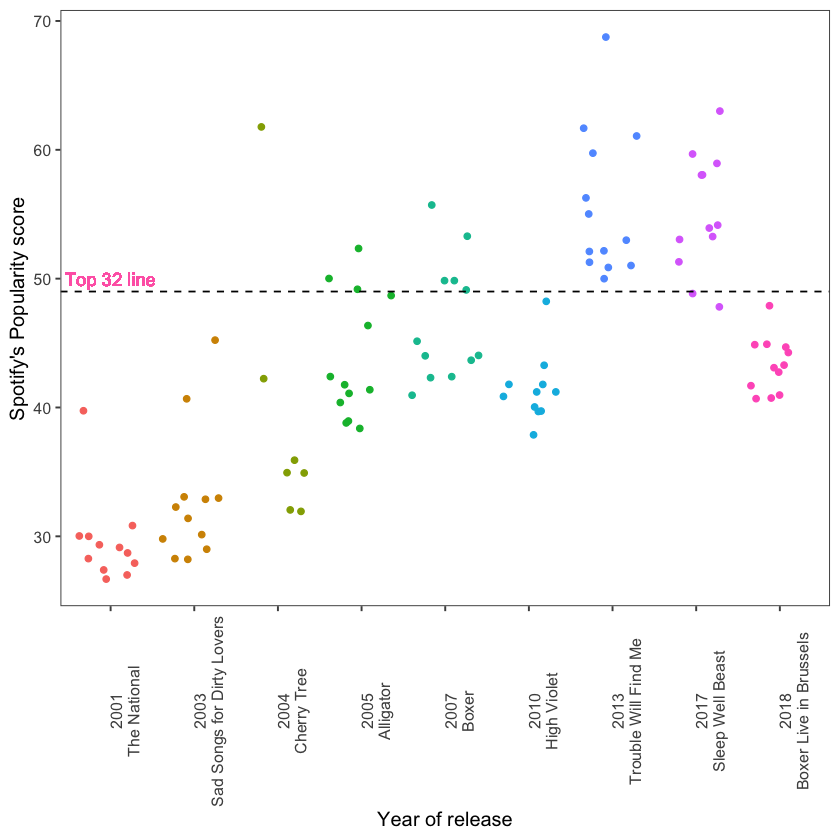

In [2]:
nonnorm_ranking = national_songs_clean  %>% 
    arrange(desc(popularity))  %>% 
    mutate(rank = row_number())  %>% 
    select(rank, "song" = name, "album" = year_album, popularity)

song_32 = nonnorm_ranking  %>% 
    filter(rank == 32)  %>% 
    pull(popularity)

p = national_songs_clean  %>% 
    mutate(year_album = str_replace(.$year_album, ", ", "\n"))  %>% 
    ggplot(aes(x = year_album, y = as.numeric(popularity), colour = year_album, text=sprintf("<br>%s</br><b>%s (%s)</b></br>", name, album.name, year)))+
    geom_jitter(alpha = 1)+
    geom_hline(yintercept = song_32, linetype = 2) +
    geom_text(aes(1, song_32+1), label= "Top 32 line", colour = "hot pink")+
    theme_few()+
    theme(axis.text.x = element_text(angle=90))+
    labs(x = "Year of release", y = "Spotify's Popularity score")+
    theme(legend.position='none')

#ggplotly(p, height = 800, tooltip = "text")

p

If we were to take Spotify's popularity score at face value (which we're not going to; read on!), then one immediate thing to point out is the disproportional number of songs that feature in the top 32 ranked song in the more recent albums, namely *Trouble Will Find Me* and *Sleep Well Beast*. This surprises me, particularly since I'm not a massive fan of *Sleep Well Beast* compared to their earlier stuff - I don't think that's too controversial to say. 

If we look at the distribution of popularity within each album in the boxplot below, the scores are still more confusing. A statistical interpretation of this plot is that *Trouble Will Find Me* and *Sleep Well Beast* have **significantly** higher popularity on Spotify than *High Violet* and *Cherry Tree*. Really?! Pfft.

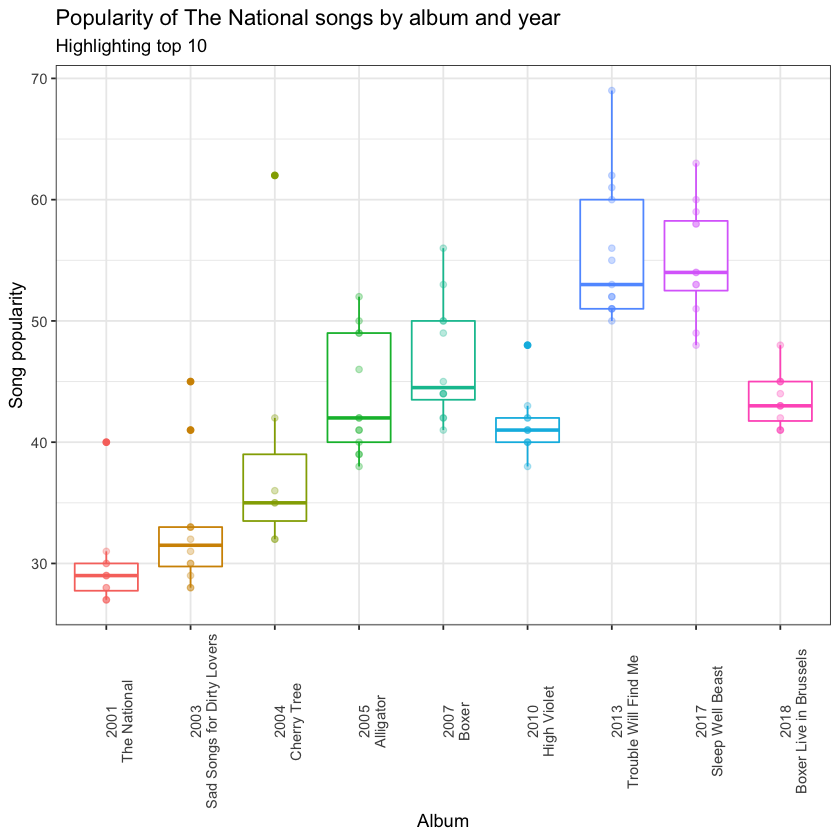

In [3]:
p = national_songs_clean  %>% 
    mutate(year_album = str_replace(.$year_album, ", ", "\n"))  %>% 
    ggplot(aes(y = popularity, x = year_album, colour = year_album, group= year_album, text=sprintf("<br>%s</br><b>%s (%s)</b></br>", name, album.name, year)))+
  geom_boxplot(show.legend = F)+
  geom_point(alpha = 0.3, show.legend = F) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90))+
  labs(y = "Song popularity", x = "Album", title = "Popularity of The National songs by album and year", 
       subtitle = "Highlighting top 10")+
theme(legend.position='none')

#ggplotly(p, tooltip = "text", height = 800)

p

## Looking at you, High Violet

For a moment, let's focus on *High Violet* to see why it is clearly suffering in the popularity rankings. If we just take year as the predictor, a linear model does pretty well to explain the popularity of songs. (The Adjusted R-squared value below tells us that this model explains roughly 76.8 per cent of the data variation and the model has overall significance (*p* < 0.05).)

In [4]:
mod = lm(log(popularity) ~ as.factor(year), data = national_songs_clean)

mod  %>% summary


Call:
lm(formula = log(popularity) ~ as.factor(year), data = national_songs_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.17576 -0.07357 -0.01512  0.05268  0.48564 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          3.38159    0.03234 104.568  < 2e-16 ***
as.factor(year)2003  0.09704    0.04573   2.122   0.0364 *  
as.factor(year)2004  0.25991    0.05328   4.878 4.30e-06 ***
as.factor(year)2005  0.39007    0.04485   8.698 9.98e-14 ***
as.factor(year)2007  0.45672    0.04573   9.986  < 2e-16 ***
as.factor(year)2010  0.34138    0.04676   7.300 8.70e-11 ***
as.factor(year)2013  0.63221    0.04485  14.097  < 2e-16 ***
as.factor(year)2017  0.62252    0.04573  13.612  < 2e-16 ***
as.factor(year)2018  0.38819    0.04573   8.488 2.79e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.112 on 95 degrees of freedom
Multiple R-squared:  0.7861,	Adjusted R-squared:  0.7681 
F-sta

And if we look at the summary stats for each album, ordered by year, it is obvious that High Violet has really suffered in terms of Spotify's popularity score. Even the album's most popular song (Bloodbuzz Ohio - arguably one of the best!!), with a popularity score of 48, is lower than *Trouble Will Find Me's* least popular song (Slipped). *Trouble Will Find Me* is good but it isn't that good. 

In [5]:
summary <- national_songs_clean  %>% 
    group_by(album.name, year)  %>% 
    summarise(`min pop` = min(popularity, na.rm = TRUE), 
             `mean pop` = round(mean(popularity, na.rm = TRUE), 2), 
             `max pop` = max(popularity, na.rm = TRUE))  %>% 
    arrange(year)

summary

album.name,year,min pop,mean pop,max pop
The National,2001,27,29.58,40
Sad Songs for Dirty Lovers,2003,28,32.75,45
Cherry Tree,2004,32,39.14,62
Alligator,2005,38,43.69,52
Boxer,2007,41,46.67,56
High Violet,2010,38,41.45,48
Trouble Will Find Me,2013,50,55.62,69
Sleep Well Beast,2017,48,55.00,63
Boxer Live in Brussels,2018,41,43.42,48


Let's then exclude *High Violet* songs from the dataset then try to predict the average popularity score using our linear model with a log transformation from above. This should tell us at least what popularity *High Violet* should have if we just factor in the year of its release. 

The actual average popularity score of *High Violet* is 41.45. This is not just less than the predicted score (43.79) but is over half a point outside of the 95% confidence interval (42.15 - 45.48) - meaning: High Violet's popularity is **REALLY** bucking the trend! 

In [6]:
actual = summary  %>% 
    filter(year == 2010)  %>% 
    select(album.name, year, `mean pop`) 

mod = lm(log(popularity) ~ year, data = national_songs_clean  %>% filter(!year %in% c(2010)))

year = 2010
newdat = data.frame(year = year)
predicted = newdat  %>% 
    cbind(predict(mod, newdata = newdat, interval = "confidence") %>% exp)

actual  %>% 
    inner_join(predicted, "year")  %>% 
    rename("predicted mean pop" = "fit", 
          "lower 95 CI" = "lwr", 
          "upper 95 CI" = "upr")

album.name,year,mean pop,predicted mean pop,lower 95 CI,upper 95 CI
High Violet,2010,41.45,43.78512,42.15264,45.48082


But really, this result is a bit surprising - if you think about it, the actual mean popularity score of the album is not that far away from the predicted score, a couple of points is nothing. However, the model above is still including 2018's live Boxer album - this album is most certainly bringing down the trendline as predicted by the linear model. If we exclude this - which we probably should any way as we're not so interested in renditions - then the mean popularity prediction is even worse for High Violet. 

If we rerun the model, now excluding *Boxer Live in Brussels*, the result gets even worse for High Violet.

In [7]:
mod = lm(log(popularity) ~ year, data = national_songs_clean  %>% filter(!year %in% c(2010, 2018)))

year = 2010
newdat = data.frame(year = year)
predicted = newdat  %>% 
    cbind(predict(mod, newdata = newdat, interval = "confidence") %>% exp)

actual  %>% 
    inner_join(predicted, "year")  %>% 
    rename(`predicted mean pop` = "fit")  %>% 
    mutate(difference = `predicted mean pop` - `mean pop`)  %>% 
    select(-c(lwr, upr))

album.name,year,mean pop,predicted mean pop,difference
High Violet,2010,41.45,46.69059,5.240591


5 points difference!! 

Then looking at our adjusted R squared again, which now has increased to 0.78 we can see that after excluding these years of songs (2010 and 2018), our model, using year as the sole predictor, has improved in terms of explaining the popularity of the remaining albums.

In [8]:
mod = lm(log(popularity) ~ as.factor(year), data = national_songs_clean  %>% filter(!year %in% c(2010, 2018)))
summary(mod)$adj.r.squared  %>% round(2)

[1] 0.78

## Why so low High Violet?

A clear trend that we can see from these plots is that despite the linear relationship between years increasing and popularity increaing, there is one notable exception: High Violet. Despite High Violet being in the latter half of The  National's discography, it doesn't seem to have benefitted in terms of Spotify's popularity score, from being more recent than say *Alligator* (five years previous) or *Boxer* (three years previous). So let's explore what's different about *High Violet*...

Note below, 2010 and 2018 albums (*High Violet* & *Boxer live*, respectively) are clear anomolies in the distribution. 

Warning message:
“Ignoring unknown aesthetics: text”Warning message:
“Ignoring unknown aesthetics: text”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 14595”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2936.6”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 8.6237e+06”

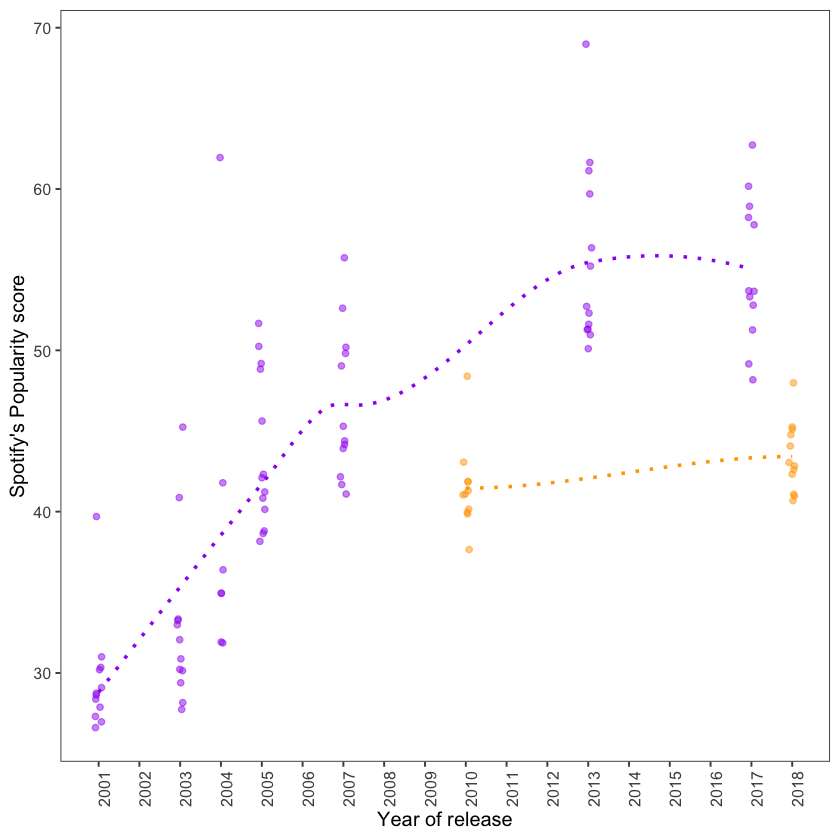

In [9]:
songs_1018 = national_songs_clean  %>% 
  filter(year == 2010 | year == 2018)  %>% 
  mutate(year_album = str_replace(.$year_album, ", ", "\n"), 
         date = paste0(year, "-01-01"),
         date = as.Date(date, "%Y-%m-%d"))

songs_rest = national_songs_clean  %>% 
  #filter(year != 2010 & year != 2018)  %>% 
  mutate(year_album = str_replace(.$year_album, ", ", "\n"), 
         popularity = ifelse(year==2010 | year==2018, NA, popularity),
         date = paste0(year, "-01-01"),
         date = as.Date(date, "%Y-%m-%d"))

p = songs_rest  %>% 
  ggplot(aes(x = date, y = popularity))+
  geom_jitter(aes(text=sprintf("<br>%s</br><b>%s (%s)</b></br>", name, album.name, year)), colour = "purple", na.rm = T, 
              width = 30, alpha = 0.5)+
  geom_smooth(na.rm = T, colour = "purple", linetype = 3, se=F, method = 'loess') +
  geom_jitter(data = songs_1018, mapping = aes(x = date, y = popularity, text=sprintf("<br>%s</br><b>%s (%s)</b></br>", name, album.name, year)), colour = "orange", width = 30, alpha = 0.5)+
  geom_smooth(data = songs_1018, mapping = aes(x = date, y = popularity), na.rm = T, se=F, colour = "orange", linetype = 3, method = 'loess') +
  theme_few()+
  scale_x_date(date_breaks = "1 year", date_labels = "%Y")+
  theme(axis.text.x = element_text(angle=90))+
  labs(x = "Year of release", y = "Spotify's Popularity score", colour= "2010/2018 album")+
  theme(legend.position='none')

#suppressWarnings(ggplotly(p, tooltip = "text", height = 800))

p

Spotify contains certain ["features"](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) of songs which are helpful when trying to describe songs in catagorical terms. Think of them as describing the unique fingerprint of a song. 

There about a dozen measurements that Spotify keep per song, covering a range of aspects, but the most useful of these features in terms of differentiating the The National songs, would be:
* **energy** - thinking *Lemonworld*, *Sea of Love*
* **valence** - a measure of happiness, the higher the score, the happier
* **acousticness**
* **loudness**
* **tempo** - hand-in-hand with **energy**

Interestingly if we just isolate these measurements, normalising all to a range of 0 - 1, and look at the distributions across year (album), 2010 (*High Violet*) certainly stands out as a very "different" album in some categories. The vertical dotted line just indicated the middle of the range (0.5) as a reference point to look at the distributions. *High Violet* is a standout album in The National's catalog is displayed best by **energy** and **loudness**, and to some extent **tempo**. The sharp spike in these categories for *High Violet* contrasts with all other years. For example, **energy** is generally evenly distributed either side of the dotted line for all years *except 2010*, which is concentrated on the positive side of the dotted line. 

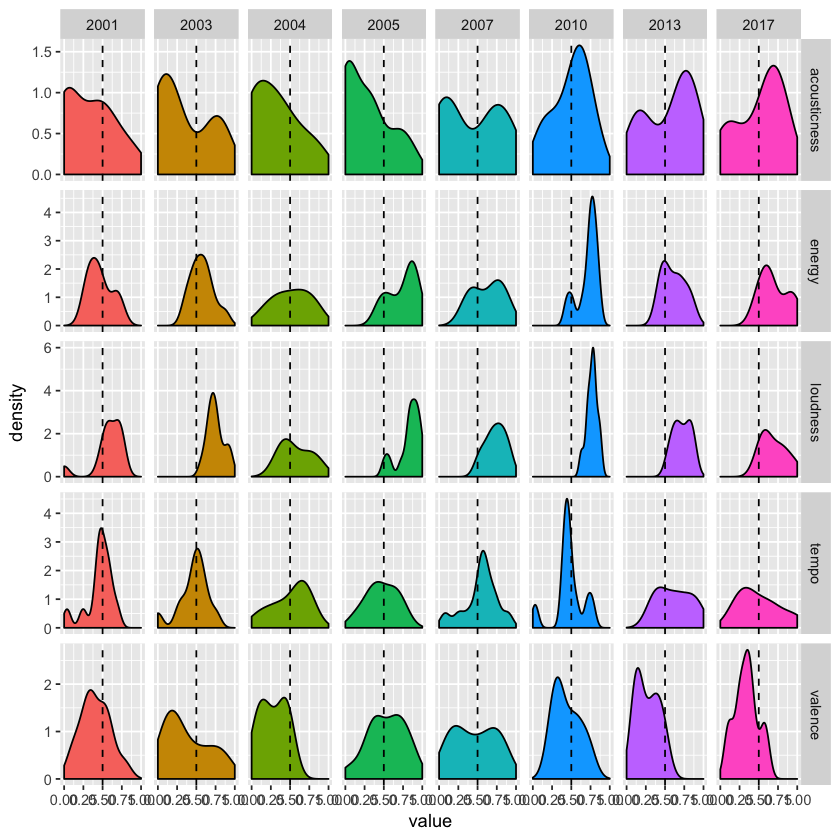

In [10]:
album_features = national_songs_clean %>% 
    filter(!year %in% "2018") %>% 
  select(name, year_album, phases, popularity, tempo, loudness, energy, acousticness, valence) %>% 
  mutate(year = str_extract(year_album, "\\d{4}")) %>% 
  select(name, year, year_album, phases, popularity, everything()) %>% 
  arrange(-as.numeric(year)) %>% 
  as_tibble() 

album_features %>% 
  mutate(tempo = (tempo - min(tempo))/(max(tempo)-min(tempo)), # normalising temp and loundess to 0-1 range
         loudness = (loudness - min(loudness))/(max(loudness)-min(loudness))) %>% 
  gather(feat, value, tempo:valence) %>% 
  ggplot(aes(value, fill = year))+
  geom_density(show.legend = FALSE) +
    geom_vline(xintercept = 0.5, linetype = 2) +
  facet_grid(feat ~ year, scales = "free_y")

Another interesting note here is the progressive changes across years. **Valence** (the measure of happiness/sadness), for instance, in *High Violet* (2010), *Trouble Will Find Me* (2013), and *Sleep Well Beast* (2017) tend to be pulled more towards 0 (*away from happiness*) than the preceeding albums. Years '10, '13, and '17 also have similarly left skewed distributions for **accousticness** which is very different for the other years. These trending changes in The National's music both started in 2010, which again supports the generally held thesis that High Violet was a turning point for The National. 

Perhaps *High Violet* was an introduction to something new that upset the fan-base at the time, but which came to be the source of its fame. It marked a departure from the garageband style sounds that were loved in Boxer and Cherry Tree and the beginning of the more highly-produced, complex sounds of Trouble Will Find Me. In otherwords, perhaps Trouble Will Find Me, the popularity apex, was just a more appealing version of what the National were trying to do with High Violet?

## Thinking in phases
<br></br>

In order to reduce the effect of time in Spotify's popularity score, one method could be to standardise the scores of each song within the historical context of that song. Specifically, contextualising a song could be organised in loosely defined phases that The National have gone through throughout their releases. 

The interesting thing about grouping the data based purely on the averages of an album's popularity is that they also align with the different labels The National have had over the past 20-odd years. A quick glance at [their discography](https://ipfs.io/ipfs/QmXoypizjW3WknFiJnKLwHCnL72vedxjQkDDP1mXWo6uco/wiki/The_National_discography.html) and we can see:
* Brassland produced *The National*, *Sad Songs for Dirty Lovers* and *Cherry Tree*
* Beggars Banquet produced *Alligator* and *Boxer*, and
* 4AD for *High Violet*, *Trouble Will Find Me* and *Sleep Well Beast*

These are some pretty descriptive groupings for The National's repertoire in terms of how their songs have changed over time. 

<br></br>

### So, why is *High Violet* so low?
<br></br>


The key question is why would we group 2010's *High Violet* on its own? Well to that, the Spotify data doesn't really explain much. It obviously bucks the trend as we've seen from the above, but why? Despite these guys being glowing of *High Violet*, it seems the album is [quite polarising amongst the fans](http://americanmaryforum.com/discussion/topic/rank-the-big-five-national-albums/). Perhaps [this article sums](https://pitchfork.com/reviews/albums/14203-high-violet/) it up best:
> *High Violet* is the sound of a band taking a mandate to be a meaningful rock band seriously, and they play the part so fully that, to some, it may be off-putting.

If we grouped it with its other 4AD bretherens, then *High Violet* would be completely overshadowed by the other's song popularity scores. That would mean that the brilliant songs like Bloodbuzz Ohio, England, Terrible Love would be lost in our quest for the top 32. So I am preferring to keep it in it's own group - taken as an anomaly - purely from a subjective, biased (hopefully informed?) judgement.

In [11]:
national_songs_clean %>% 
    group_by(phases, album.name)  %>% 
    summarise(mean = mean(popularity), 
             std_dev = sd(popularity)) %>% 
    group_by(phases)  %>% 
    summarise(albums = paste(album.name, collapse = ", "), 
             "avg popularity" = mean(mean), 
             "std deviation" = mean(std_dev))

phases,albums,avg popularity,std deviation
1,"Cherry Tree, Sad Songs for Dirty Lovers, The National",33.82540,6.446266
2,"Alligator, Boxer",45.17949,4.824346
3,High Violet,41.45455,2.544156
4,"Sleep Well Beast, Trouble Will Find Me",55.30769,5.182303
5,Boxer Live in Brussels,43.41667,2.108784


Just by looking at the plot below we can kind of see steps in the popularity of albums. 

*The National*, *Sad Songs for Dirty Lovers* and *Cherry Tree* have similar averages in overall popularity; *Alligator* and *Boxer* another group; *High Violet* perhaps forms its own grouping given what we've seen above; then *Trouble Will Find Me* and *Sleep Well Beast* make up the last group. 

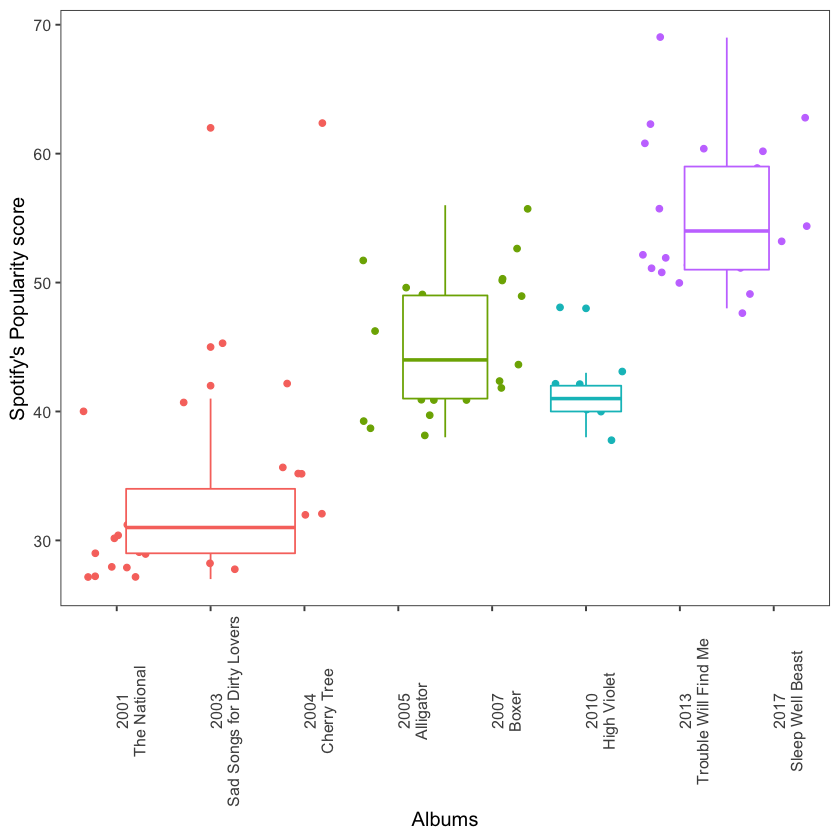

In [12]:
p = national_songs_clean  %>% 
    filter(year!=2018) %>% 
    mutate(year_album = str_replace(.$year_album, ", ", "\n"))  %>% 
    ggplot(aes(x = year_album, y = popularity, colour = factor(phases)))+
      geom_jitter(show.legend = F)+
      geom_boxplot(aes(group = phases), show.legend = F)+
      theme_few()+
      theme(axis.text.x = element_text(angle=90), legend.position = "none")+
      labs(x = "Albums", y = "Spotify's Popularity score")
#ggplotly(p, height = 800)

p

Alright, there's definitely more we could do to define these groupings (other more fancy analysis (cluster?) comes to mind) but I've already written too much. 

So let's take these groupings, from which we can standardise song popularity across the whole catalogue. This would be an attempt to limit the influence of time in Spotify's scores. 


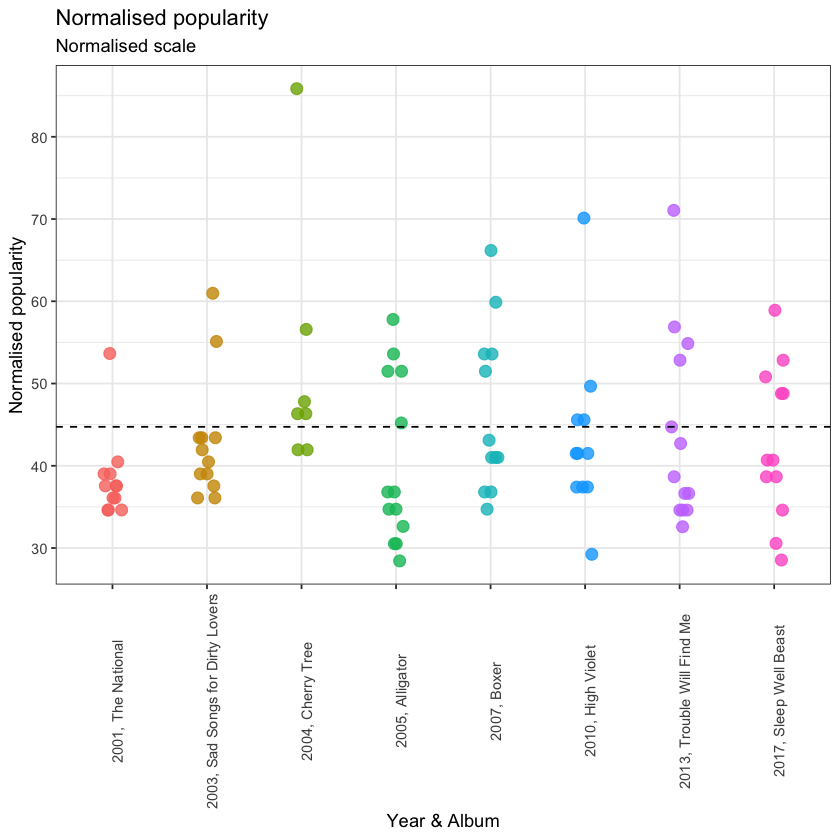

In [13]:
song_phases = national_songs_clean %>% 
  filter(year!=2018) %>% # removing Boxer Live album
  group_by(phases) %>% 
  mutate(phase_mean = mean(popularity), 
            phase_sd = sd(popularity)) %>% 
  rowwise() %>% 
  mutate(z = (popularity - phase_mean)/phase_sd) %>% 
  arrange(desc(z)) %>% 
  ungroup() %>% 
  mutate(rowname = 1:nrow(.)) %>% 
  mutate(label = ifelse(rowname <= 32, name, NA)) %>% 
  mutate(sd = sd(popularity), 
         mean = mean(popularity), 
         normal_popularity = z*sd+mean) %>% 
  select(rank = rowname, year_album, name, normal_popularity, label)

song_32 = song_phases  %>% 
    filter(rank == 32)  %>% 
    pull(normal_popularity)

p = song_phases %>% 
  ggplot(aes(x = year_album, y = normal_popularity, 
             text=sprintf("<br>%s</br><b>%s</b></br>", name, round(normal_popularity, 2))))+
  #geom_boxplot(aes(colour = year_album), show.legend = F)+
  geom_jitter(alpha = 0.8, aes(colour = year_album), size = 3, show.legend = F, width = 0.1) +
  geom_hline(yintercept = song_32, linetype = 2) +
  geom_text(aes(1, song_32, label = "Top 32 line"), vjust = -50, colour = "hot pink")+
  labs(x = "Year & Album", y = "Normalised popularity", title = "Normalised popularity", subtitle = "Normalised scale")+
  theme_bw()+
  theme(axis.text.x = element_text(angle=90))+
  theme(legend.position='none')

#ggplotly(p, tooltip = "text", height = 700)
p

And this brings us to the best estimate  of The National's song popularity based on Spotify's data that I can muster.

One immediate observation is that there is a more even distribution of Top 32 most popular songs across all albums, than what we saw above. Personally, I am also more comfortable with the fewer Sleep Well Beast songs in the top 32 than before! And yes, *High Violet* now features in the Top 32 with Bloodbuzz, Sorrow, England and Terrible Love!

In [14]:
norm_32 = song_phases %>% 
  filter(rank <= 32) %>% 
    mutate(normal_popularity = round(normal_popularity, 2))  %>% 
    rename("album" = "year_album", 
          "song" = "name", 
          "adjusted popularity"= "normal_popularity")  %>% 
    select(rank, "song", album, "adjusted popularity")

norm_32  %>% 
    inner_join(nonnorm_ranking, c("song", "album"), suffix = c("_normalised", "_nonnormalised"))  %>% 
    mutate(`ranking difference` = rank_nonnormalised - rank_normalised)  %>% 
    select(rank_normalised, song, album, `adjusted popularity`, `ranking difference`)

rank_normalised,song,album,adjusted popularity,ranking difference
1,About Today,"2004, Cherry Tree",85.85,2
2,I Need My Girl,"2013, Trouble Will Find Me",71.06,-1
3,Bloodbuzz Ohio,"2010, High Violet",70.12,32
4,Fake Empire,"2007, Boxer",66.17,7
5,Lucky You,"2003, Sad Songs for Dirty Lovers",60.97,36
6,Slow Show,"2007, Boxer",59.88,12
7,The System Only Dreams in Total Darkness,"2017, Sleep Well Beast",58.91,-5
8,Mr. November,"2005, Alligator",57.78,13
9,This Is The Last Time,"2013, Trouble Will Find Me",56.88,-5
10,All the Wine,"2004, Cherry Tree",56.58,42


I'm not saying I agree with this list completely. There are some songs which obviously have a right place, but there's also a number of songs that don't feature here and which should! Where's Sea of Love for examples?? But it gives us a benchmark from which to compare people's choices. And it's interesting given that this data is based on millions of Spotify plays, so there is certainly substance to it. 


## Interesting Tweets

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">The cool thing about The National is that if you’re having a sad day you can listen to High Violet and become 100x sadder</p>&mdash; Zach Cole (@ZachACole) <a href="https://twitter.com/ZachACole/status/1001674229769822208?ref_src=twsrc%5Etfw">May 30, 2018</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">I know I&#39;m 7 years late but: the album High Violet by the National is really great.</p>&mdash; Corey J Brewer (@CoreyJBrewer) <a href="https://twitter.com/CoreyJBrewer/status/885185495134752768?ref_src=twsrc%5Etfw">July 12, 2017</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>


<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">After a couple of years off, I&#39;m back to playing The National&#39;s High Violet album on loop. One of the all-time greats</p>&mdash; Jamie Graham (@jamie_graham9) <a href="https://twitter.com/jamie_graham9/status/841048717595676673?ref_src=twsrc%5Etfw">March 12, 2017</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>


<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">I&#39;ve mocked you for a great many things (sweaters, abacuses, etc.) but not The National. We just disagreed about the merits of Boxer vs. High Violet because I got into them later because you&#39;re old.</p>&mdash; James Queally (@JamesQueallyLAT) <a href="https://twitter.com/JamesQueallyLAT/status/1143749120349224962?ref_src=twsrc%5Etfw">June 26, 2019</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
